In [1]:
from matplotlib import pyplot as plt
from copy import deepcopy
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"

In [2]:
plt.rcParams["figure.figsize"] = [10, 10]

## Impact of Network Sparsity on the Effective Adjacency Matrix of a Trained Reservoir Computer

Reservoir computer dynamics are governed by two equations:

$ \frac{d}{dt}\mathbf{r}(t) = \gamma[\, -\mathbf{r}(t) + \text{tanh}\big(\mathbf{A}\mathbf{r}(t) + \sigma \mathbf{W}_{\text{in}}\mathbf{u}(t)\big) \,]$

$\frac{d}{dt}\hat{\mathbf{r}}(t) = \gamma[-\hat{\mathbf{r}}(t) + \text{tanh}\big(\mathbf{A}\hat{\mathbf{r}}(t) + \sigma \mathbf{W}_{\text{in}}\mathbf{W}_{\text{out}}\hat{\mathbf{r}}(t)\big)$

The first equation is used to train the reservoir. In this equation, the nodes of the reservoir interact according to an adjacency matrix $\mathbf{A}$ and are perturbed by a desired output signal $\mathbf{u}$ transformed by $W_{\text{in}}$. The $-\mathbf{r}(t)$ term introduces an individual node activation decay when $\gamma$ is positive. Overall this means that the nodes in the reservoir naturally decay, but are excited by the combination of $\mathbf{A} \mathbf{r}(t)$ and $W_{in} \mathbf{u}(t)$. The hyperbolic tangent function is used to threshold exitiations from node interactions and stimulation from the desired output signal by ensuring that they never leave the interval $(-1,1)$.

During training, the first equation is solved for some time interval $(0, T)$. The solution $\mathbf{r}(t)$ is then projected onto $\mathbf{u}(t)$ via a linear mapping $W_{\text{out}}$. This mapping is the mapping that minimizes $||\mathbf{u}(t) - W_{\text{out}} \mathbf{r}(t)||_2 + \alpha || W_{\text{out}} ||_2$ for some amount of regularization ($\alpha$).

After training, the reservoir computer is governed by the second equation. At this point it is no longer dependent on the desired output signal $\mathbf{u}(t)$. It becomes a stand-alone dynamical system. 

However, from the network science perspective the structure of the reservoir network changes drastically after training. Where previously, reservoir node interactions were governed by $A$ and then stimulated by $W_{in} \mathbf{u}$, they are now governed by $\mathbf{A}\hat{\mathbf{r}}(t) + \sigma \mathbf{W}_{\text{in}}\mathbf{W}_{\text{out}}\hat{\mathbf{r}}(t)$, making the effective adjacency matrix $\mathbf{A} + \sigma \mathbf{W}_{\text{in}}\mathbf{W}_{\text{out}}$.

A few limited experiments found that $ \mathbf{W}_{\text{in}}\mathbf{W}_{\text{out}} $ did not have a clear component structure. But further work is needed to investigate the structure of the effective adjacency matrix

### Constants

In [3]:
DIFF_EQ_PARAMS = {
                  "x0": [-20, 10, -.5],
                  "begin": 0,
                  "end": 85,
                  "timesteps": 85000,
                  "train_per": .889,
                  "solver": lorenz_equ,
                  "clip": 40
                 }

RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",

              "res_sz": 15,
              "activ_f": np.tanh,
              "connect_p": .4,
              "spect_rad": 2.0,
              "gamma": 5,
              "sigma": .14,
              "sparse_res": True,
             }

### Functions

In [4]:
def remove_percent_edges(A, p):
    return remove_edges(A, floor(p * np.sum(A != 0)))

def train_rc(topo, remove_p=0.0, spect_rad=2.0, topo_p=None, n=2500):
    prms = deepcopy(RES_PARAMS)
    diff_eq_params = deepcopy(DIFF_EQ_PARAMS)
    # Make rc
    A = remove_percent_edges(generate_adj(topo, topo_p, n=n), remove_p)
    
    prms["spect_rad"] = spect_rad
    rc = ResComp(A, **prms)
    # Generate random orbit
    diff_eq_params["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(diff_eq_params)
    err = rc.fit(train_t, u)
    pred = how_long_accurate(u(test_t), rc.predict(test_t), tol=TOL)
    return rc, err, pred

def effective_adj(rc):
    return rc.res + rc.sigma * rc.W_in @ rc.W_out
    
def plot_matrix(A, log=False, title="Effective Adj Matrix"):
    if log:
        A = np.log(np.abs(A))
        title += " (Pictured: log(A))"
    plt.imshow(A, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.show()

### Train a Reservoir Computer

In [5]:
rc, err, pred = train_rc("barab2")
print(f"Error {err} \n Acc Duration {pred}")

Error 0.008252350299073794 
 Acc Duration 449


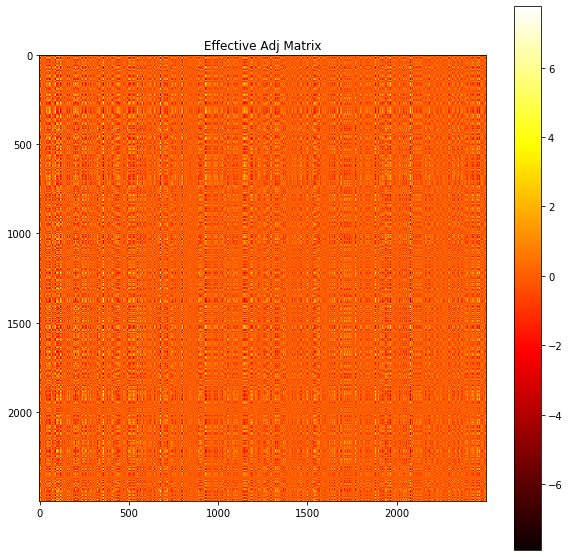

In [6]:
eadj = effective_adj(rc)
plot_matrix(eadj)

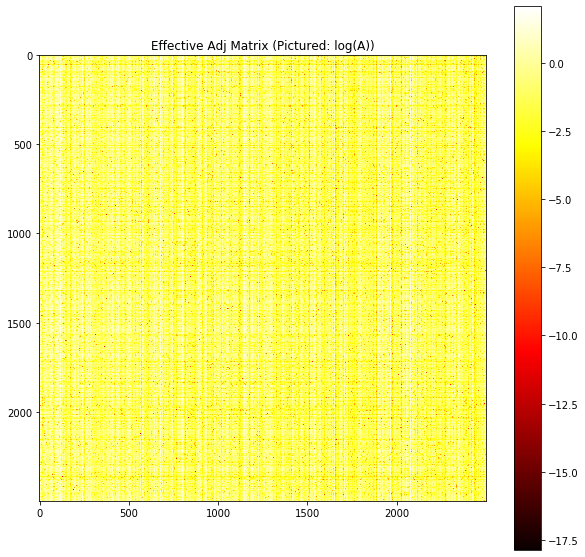

In [7]:
plot_matrix(eadj, log=True)